In [1]:
# load packages
import pandas as pd
import numpy as np
import string
import re
import nltk

nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package punkt to /Users/jff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jff/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/jff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# optional: for plotting
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# path to test RSA corpus
path_rsa = '../rsa/test_corpus.csv'

In [4]:
df_rsa = pd.read_csv(path_rsa)
df_rsa.head(5)

,snippet,tag_0,tag_1,tag_2,source
0,C. Climate Change Impacts on Local Economies ...,FACT BASE,Current & Future data,Economic systems,planning-framework-climate-resilient-economy-5...
1,Primary economic activities The assessment ne...,FACT BASE,Current & Future data,Economic systems,planning-framework-climate-resilient-economy-5...
2,The team might also find it helpful to categor...,FACT BASE,Current & Future data,Economic systems,planning-framework-climate-resilient-economy-5...
3,Businesses with significant inventory on site....,FACT BASE,Current & Future data,Economic systems,planning-framework-climate-resilient-economy-5...
4,Commercial Operations Commercial operations...,FACT BASE,Current & Future data,Economic systems,planning-framework-climate-resilient-economy-5...


In [5]:
# count unique tags in each tag level
print('tag_0:\n', df_rsa['tag_0'].value_counts(), '\n')
print('tag_1: \n', df_rsa['tag_1'].value_counts(), '\n')
print('tag_2: \n', df_rsa['tag_2'].value_counts(), '\n')

tag_0:
 STRATEGY IDENTIFICATION    179
FACT BASE                   20
Name: tag_0, dtype: int64 

tag_1: 
 Strategy Action          179
Current & Future data     20
Name: tag_1, dtype: int64 

tag_2: 
 Financing and Funding                99
Regulatory policy and legislation    80
Economic systems                     20
Name: tag_2, dtype: int64 



<AxesSubplot:>

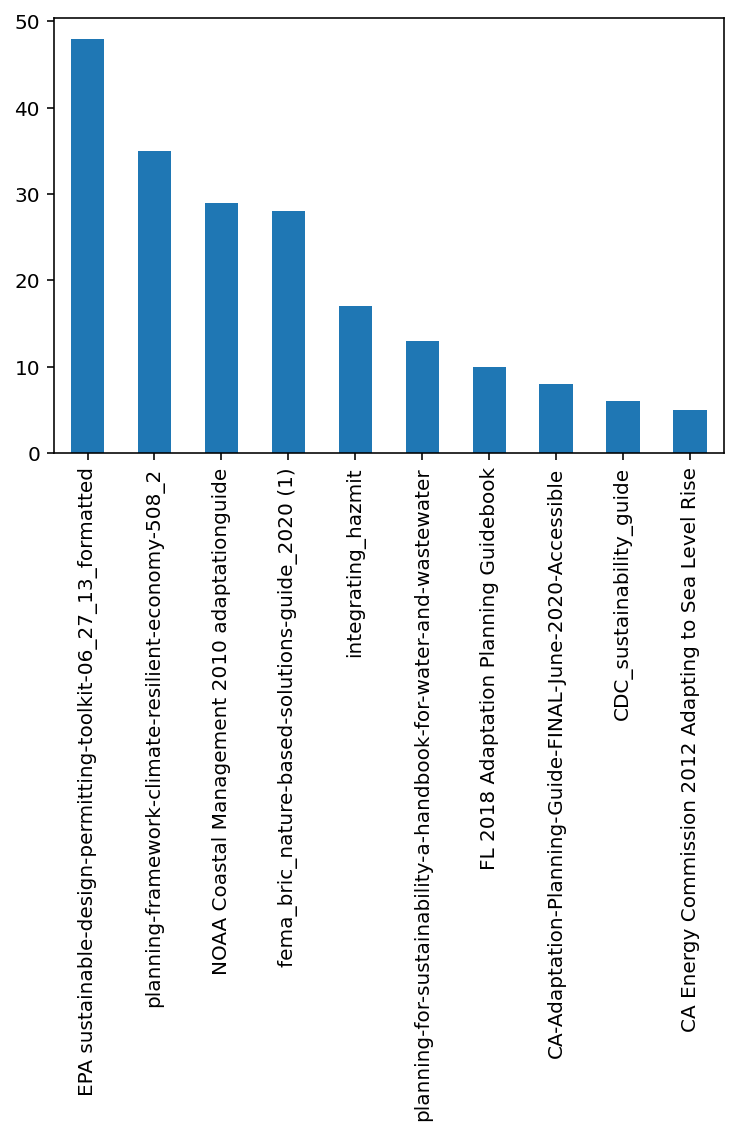

In [6]:
# plot snippets per source document
df_rsa['source'].value_counts().plot.bar()

In [7]:
# extracting the number of examples of each tag level 2
FF_len = df_rsa[df_rsa['tag_2'] == 'Financing and Funding'].shape[0]
Reg_len = df_rsa[df_rsa['tag_2'] == 'Regulatory policy and legislation'].shape[0]
Ec_len = df_rsa[df_rsa['tag_2'] == 'Economic systems'].shape[0]

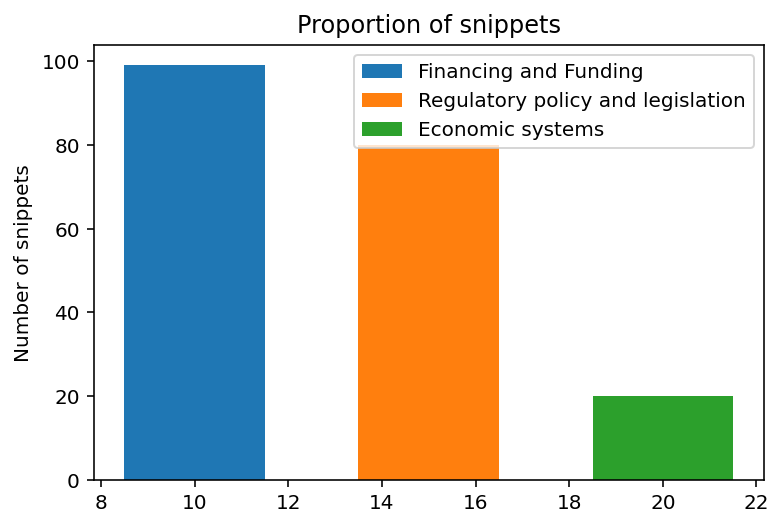

In [8]:
# plot snippets by document source
plt.bar(10,FF_len,3, label="Financing and Funding")
plt.bar(15,Reg_len,3, label="Regulatory policy and legislation")
plt.bar(20,Ec_len,3, label="Economic systems")
plt.legend()
plt.ylabel('Number of snippets')
plt.title('Proportion of snippets')
plt.show()

In [9]:
# get list of snippets and labels
text = df_rsa['snippet'].apply(str).tolist()
source = df_rsa['source'].apply(str).tolist()

In [10]:
print(text[2])

The team might also find it helpful to categorize economic activity based on characteristics that  could put businesses at particular risk or position them to capitalize on opportunities, such as:


In [11]:
# set words to lower case
text = [s.lower() for s in text]
# remove punctuation and other special characters
text = [re.sub(r'[^\w]', ' ', re.sub(r"[^a-zA-Z0-9]", " ", s)) for s in text]

In [12]:
# drop nan segments! 
# TODO: drop *before* import (ie, in test_corpus.csv)
text = list(filter(lambda x: x != 'nan', text))
source = [source[i] for i in [i for i, x in enumerate(text) if text != 'nan']]

In [13]:
# tokenize the snippets
text_tokens = [word_tokenize(s) for s in text]

In [14]:
# remove stopwords
text_tokens_no_stop = [[word for word in s if word not in stop_words] for s in text_tokens]
text_no_stop = [" ".join(tokens) for tokens in text_tokens_no_stop]

In [15]:
print(text_no_stop[2])

team might also find helpful categorize economic activity based characteristics could put businesses particular risk position capitalize opportunities


In [16]:
# Optional: stemming/lemmatization

stemmed_tokens = [[stemmer.stem(word) for word in s] for s in text_tokens_no_stop]
text_stemmed = [" ".join(tokens) for tokens in stemmed_tokens]

lemmed_tokens = [[WordNetLemmatizer().lemmatize(word) for word in s] for s in text_tokens_no_stop]
text_lemmed = [" ".join(tokens) for tokens in lemmed_tokens]

In [17]:
print(text_stemmed[2])
print('\n')
print(text_lemmed[2])

team might also find help categor econom activ base characterist could put busi particular risk posit capit opportun


team might also find helpful categorize economic activity based characteristic could put business particular risk position capitalize opportunity


In [18]:
# perform tf-idf for each label (source document), then aggregate across corpus
# HT: https://stackoverflow.com/a/57770227/5037901

def tfidf_means(tfidf, names):
    t = tfidf.todense()
    t[t==0] = np.nan
    means = np.nanmean(t, axis=0)
    means = dict(zip(names, means.tolist()[0]))
    return means


def tfidf_agg(text, source, tfidf_vec, top_k=10):
    labels = list(set(source))
    tfidf_dict = {}
    names_dict = {}
    means_dict = {}
    result_df = pd.DataFrame()
    for label in labels:
        s = [text[i] for i in [i for i, x in enumerate(source) if x == label]]
        # TODO: append?
        # 1. tf-idf for label
        tfidf_dict[label] = tfidf_vec.fit_transform(s) 
        names_dict[label] = tfidf_vec.get_feature_names()
        # 2. get term means
        means_dict[label] = tfidf_means(tfidf_dict[label], names_dict[label])
        # 3. get top k terms
        tfidf = tfidf_dict[label].todense()
        # Argsort the full TFIDF dense vector
        ordered = np.argsort(tfidf*-1)
        for i, doc in enumerate(s):
            result = {}
            for t in range(top_k):
                result[names_dict[label][ordered[i,t]]] = means_dict[label][names_dict[label][ordered[i,t]]]
        result_df[label] = result
    result_df.index = range(top_k)
        
    return result_df, tfidf_dict, names_dict, means_dict



In [19]:
# tf-idf using defaults
tfidf_default = TfidfVectorizer()

result_df, tfidf_dict, names_dict, means_dict = tfidf_agg(text, source, tfidf_default)

result_df[0:5]

,planning-framework-climate-resilient-economy-508_2,EPA sustainable-design-permitting-toolkit-06_27_13_formatted,planning-for-sustainability-a-handbook-for-water-and-wastewater,CA-Adaptation-Planning-Guide-FINAL-June-2020-Accessible,integrating_hazmit,fema_bric_nature-based-solutions-guide_2020 (1),NOAA Coastal Management 2010 adaptationguide,CDC_sustainability_guide,CA Energy Commission 2012 Adapting to Sea Level Rise,FL 2018 Adaptation Planning Guidebook
0,potable,historic,hazard,floodplain,phasing,estate,strategies,redevelopment,development,or
1,rainwater,policy,areas,protection,grading,disclosure,and,restrictions,criteria,the
2,plumbing,preservation,protection,ordinance,construction,real,to,2000,conservation,sea
3,non,buildings,prohibit,restoration,clearing,000,or,park,cluster,level
4,exterior,sustainable,infrastructure,incentives,ordinance,pooling,plans,page,ordinances,rise


In [20]:
# defaults but pre-processed
result_df, tfidf_dict, names_dict, means_dict = tfidf_agg(text_lemmed, source, tfidf_default)

result_df[0:5]

,planning-framework-climate-resilient-economy-508_2,EPA sustainable-design-permitting-toolkit-06_27_13_formatted,planning-for-sustainability-a-handbook-for-water-and-wastewater,CA-Adaptation-Planning-Guide-FINAL-June-2020-Accessible,integrating_hazmit,fema_bric_nature-based-solutions-guide_2020 (1),NOAA Coastal Management 2010 adaptationguide,CDC_sustainability_guide,CA Energy Commission 2012 Adapting to Sea Level Rise,FL 2018 Adaptation Planning Guidebook
0,plumbing,historic,hazard,floodplain,phasing,estate,strategy,redevelopment,development,sea
1,potable,preservation,plan,protection,grading,disclosure,policy,restriction,criterion,rise
2,exterior,sustainable,area,restoration,construction,real,regulation,2000,conservation,area
3,harvested,building,protection,incentive,clearing,000,evaluation,obtaining,cluster,level
4,non,policy,prohibit,mitigation,requirement,planned,category,obtain,ordinance,retreat


In [21]:
# comparison with count by frequencies

def count_means(tfidf, names):
    t = tfidf.todense()
    means = np.nanmean(t, axis=0)
    means = dict(zip(names, means.tolist()[0]))
    return means


def count_agg(text, source, tfidf_vec, top_k=10):
    labels = list(set(source))
    tfidf_dict = {}
    names_dict = {}
    means_dict = {}
    result_df = pd.DataFrame()
    for label in labels:
        s = [text[i] for i in [i for i, x in enumerate(source) if x == label]]
        # TODO: append?
        # 1. tf-idf for label
        tfidf_dict[label] = tfidf_vec.fit_transform(s) 
        names_dict[label] = tfidf_vec.get_feature_names()
        # 2. get term means
        means_dict[label] = count_means(tfidf_dict[label], names_dict[label])
        # 3. get top k terms
        tfidf = tfidf_dict[label].todense()
        # Argsort the full TFIDF dense vector
        ordered = np.argsort(tfidf*-1)
        for i, doc in enumerate(s):
            result = {}
            for t in range(top_k):
                result[names_dict[label][ordered[i,t]]] = means_dict[label][names_dict[label][ordered[i,t]]]
        result_df[label] = result
    result_df.index = range(top_k)
        
    return result_df, tfidf_dict, names_dict, means_dict



In [22]:
count_vec = CountVectorizer()

result_df, tfidf_dict, names_dict, means_dict = count_agg(text_lemmed, source, count_vec)

result_df[0:5]

,planning-framework-climate-resilient-economy-508_2,EPA sustainable-design-permitting-toolkit-06_27_13_formatted,planning-for-sustainability-a-handbook-for-water-and-wastewater,CA-Adaptation-Planning-Guide-FINAL-June-2020-Accessible,integrating_hazmit,fema_bric_nature-based-solutions-guide_2020 (1),NOAA Coastal Management 2010 adaptationguide,CDC_sustainability_guide,CA Energy Commission 2012 Adapting to Sea Level Rise,FL 2018 Adaptation Planning Guidebook
0,local,historic,area,floodplain,ordinance,estate,strategy,redevelopment,development,area
1,harvested,preservation,hazard,protection,grading,disclosure,policy,restriction,criterion,sea
2,building,ordinance,infrastructure,restoration,requirement,real,plan,2000,conservation,rise
3,allow,design,plan,mitigation,clearing,000,regulation,obtaining,ordinance,level
4,code,building,avoid,ordinance,phasing,planned,evaluation,obtain,cluster,long


In [23]:
# tf-idf with options
tfidf_sublinear_3grams = TfidfVectorizer(
    analyzer='word',
    # n-gram range (note: unit is 'word')
    ngram_range=(1,3),
    # maximum document frequency
    max_df = 0.9,    
    # minimum document frequency cutoff
    min_df = 0,
    # TODO: remove stop words *before* tfidf
    stop_words = 'english',
    sublinear_tf=True
)

result_df, tfidf_dict, names_dict, means_dict = tfidf_agg(text, source, tfidf_sublinear_3grams)

result_df[0:5]

,planning-framework-climate-resilient-economy-508_2,EPA sustainable-design-permitting-toolkit-06_27_13_formatted,planning-for-sustainability-a-handbook-for-water-and-wastewater,CA-Adaptation-Planning-Guide-FINAL-June-2020-Accessible,integrating_hazmit,fema_bric_nature-based-solutions-guide_2020 (1),NOAA Coastal Management 2010 adaptationguide,CDC_sustainability_guide,CA Energy Commission 2012 Adapting to Sea Level Rise,FL 2018 Adaptation Planning Guidebook
0,ensure local building,historic,hazard,floodplain,phasing requirements,real,strategies,redevelopment restrictions,development,sea
1,building plumbing,buildings policy,areas,floodplain protection,construction phasing,real estate,plans regulations,redevelopment,development criteria,private property
2,exterior non potable,design historic,hazard areas,protection,construction,real estate disclosure,improvement infrastructure,restrictions,development criteria ordinances,dealing
3,exterior non,historic buildings,prohibit,floodplain protection mitigation,phasing,estate,regulations policy,operational practices financial,criteria ordinances cluster,sea level
4,rainwater exterior non,sustainable design historic,protection,floodplain protection ordinance,grading,estate disclosure,improvement infrastructure projects,operational practices,ordinances cluster,rise


In [24]:
# comparison on jane austen corpus
nltk.download('gutenberg')
from nltk.corpus import gutenberg

# sample text
emma = gutenberg.sents("austen-emma.txt")
persuasion = gutenberg.sents("austen-persuasion.txt")
sense = gutenberg.sents("austen-sense.txt")

[nltk_data] Downloading package gutenberg to /Users/jff/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [25]:
# convert to sentences
text_emma = [" ".join(s) for s in emma]
text_persuasion = [" ".join(s) for s in persuasion]
text_sense = [" ".join(s) for s in sense]

In [26]:
# set words to lower case
text_emma = [s.lower() for s in text_emma]
# remove punctuation and other special characters
text_emma = [re.sub(r'[^\w]', ' ', re.sub(r"[^a-zA-Z0-9]", " ", s)) for s in text_emma]

text_persuasion = [s.lower() for s in text_persuasion]
# remove punctuation and other special characters
text_persuasion = [re.sub(r'[^\w]', ' ', re.sub(r"[^a-zA-Z0-9]", " ", s)) for s in text_persuasion]

text_sense = [s.lower() for s in text_sense]
# remove punctuation and other special characters
text_sense = [re.sub(r'[^\w]', ' ', re.sub(r"[^a-zA-Z0-9]", " ", s)) for s in text_sense]

In [27]:
# stack lists and create labels
label_emma = ['emma'] * len(text_emma)
label_persuasion = ['persuasion'] * len(text_persuasion)
label_sense = ['sense'] * len(text_sense)

text_austen = text_emma + text_persuasion + text_sense
label_austen = label_emma + label_persuasion + label_sense

In [28]:
print(len(text_austen))

16498


In [29]:
result_df, tfidf_dict, names_dict, means_dict = tfidf_agg(text_austen, label_austen, tfidf_default)

result_df[0:5]

,sense,emma,persuasion
0,end,finis,finis
1,the,000,preliminary
2,10,possibilities,prejudices
3,possibility,possession,prejudice
4,possessor,possesses,preferring


In [30]:
result_df, tfidf_dict, names_dict, means_dict = tfidf_agg(text_austen, label_austen, tfidf_sublinear_3grams)

result_df[0:5]

,sense,emma,persuasion
0,end,finis,finis
1,persuaded elinor,000,10
2,persuaded conclusion rest,pleading poor,place worth occupying
3,persuaded conclusion,pleading cause gave,placed
4,persuaded communication make,pleading cause,placed anne
